In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, multivariate_t, chi2
import DyGraph as dg
from sklearn.preprocessing import StandardScaler
import tqdm
import seaborn as sns
import networkx as nx
import pandas as pd
import requests
import geopandas as gpd
import datetime

esg data

In [2]:

def fetch_raw_data(folder_path):
    """
    Function to fetch all data. Simply to make sure the data is the same in each analysis
    
    """
    price_data = pd.read_csv(folder_path+ "raw/YAHOO_PRICE.csv")
    ESG_data = pd.read_excel(folder_path+"raw/YAHOO_PRICE_ESG.xlsx", sheet_name= 'ESG')
    asset_profiles = pd.read_excel(folder_path+"raw/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 

    assert np.all(np.isin(np.unique(ESG_data['ticker']),np.unique(price_data['ticker'])))


    esg_series = ESG_data.copy()  
    esg_series['timestamp'] = pd.to_datetime(esg_series['timestamp'])
    min_date = datetime.datetime(2014,10, 1)
    max_date = np.max(ESG_data['timestamp'])
    esg_series['date'] = esg_series['timestamp'].dt.date
    print(min_date)
    print(max_date)
    esg_series


    # Create a series of days, which will then be joined with esg_series, To create "daily" ESG.
    dates = pd.DataFrame({'date':pd.date_range(min_date,max_date,freq='d')})
    dates['date'] = dates['date'].dt.date

    # Pivot the esg data frame to have each row a ESG score at a given date (the index) and the columns a stock frame where index is monthly
    esg_pivot = esg_series[['ticker', 'esgScore', 'date']].copy()
    esg_pivot_diff =pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker').diff().iloc[1:]#  np.log(pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker').pct_change().iloc[1:] + 1)
    esg_pivot = pd.pivot_table(esg_pivot, values = 'esgScore', index = 'date', columns= 'ticker')
    esg_pivot = pd.merge(dates, esg_pivot, how = 'left', left_on='date', right_index=True)
    esg_pivot_diff = pd.merge(dates, esg_pivot_diff, how = 'left', left_on='date', right_index=True)
    esg_pivot.set_index('date', inplace= True)
    esg_pivot_diff.set_index('date', inplace= True)
    esg_pivot = esg_pivot.loc[:, esg_pivot.count() >20]  # remove observations with lass than 20 observations
    esg_pivot_diff = esg_pivot_diff.loc[:, esg_pivot_diff.count() >20]



    # Create a dictionary which keeps track of which companies belong to which sector
    sector_classification = dict()
    for company in asset_profiles['ticker']:
        sector_of_company = asset_profiles['sector'].loc[asset_profiles['ticker'] == company].iloc[0]
        if sector_of_company not in sector_classification.keys():
            sector_classification[sector_of_company] = list()
        sector_classification[sector_of_company].append(company)


    # LOG RETURN
    price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
    price_filtered = price_data.loc[price_data['timestamp'] > datetime.datetime(2014,9, 1), price_data.columns]
    price_filtered['date'] = price_filtered['timestamp'].dt.date

    price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()

    # set stock as pivot
    adjclose_pivot = price_filtered[['ticker', 'adjclose', 'date']].copy() 
    adjclose_pivot = adjclose_pivot.dropna()  # Drop rows which contain missing values
    adjclose_pivot = pd.pivot_table(adjclose_pivot, values = 'adjclose', index = 'date', columns= 'ticker')

    # Get log return
    price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
    price_pivot['return'] = np.log(1 + price_pivot['return'])
    price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
    price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')

    # Let's order the columns by sector
    company_df = pd.DataFrame({'ticker': np.array(price_pivot.columns)})
    company_df = pd.merge(company_df, asset_profiles, on='ticker', how = 'left')
    company_df['track_index'] = np.array(range(company_df.shape[0]))
    company_df = company_df.sort_values(by = 'sector')
    price_pivot = price_pivot.iloc[:, company_df['track_index']]


    sector_classification = dict()
    for company in asset_profiles['ticker']:
        sector_of_company = asset_profiles['sector'].loc[asset_profiles['ticker'] == company].iloc[0]
        if sector_of_company not in sector_classification.keys():
            sector_classification[sector_of_company] = list()
        sector_classification[sector_of_company].append(company)


    price_pivot = price_pivot.dropna(axis = 1)



    return price_pivot, esg_pivot, sector_classification, adjclose_pivot

In [3]:
price_pivot, esg_pivot, sector_classification, adjclose_pivot = fetch_raw_data('../data/panmure/')

2014-10-01 00:00:00
2022-02-01 00:00:00


In [4]:
esg_refined_no_diff = pd.read_pickle("../../MMD_Graph_Diversification/data/tidy/esg_refined_no_diff.pkl")
esg_refined_no_diff

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-10-01,21.15,51.16,12.86,16.32,26.52,14.43,30.05,9.55,14.65,17.29,...,22.695,28.62,27.34,35.43,19.86,8.325,20.20,35.44,48.79,22.27
2014-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
adjclose_pivot.index = pd.to_datetime(adjclose_pivot.index)

In [6]:
esg_refined_no_diff['A'].dropna().diff().dropna()

date
2014-11-01    2.00
2014-12-01    0.00
2015-01-01    0.00
2015-02-01    0.00
2015-03-01   -2.00
              ... 
2021-02-01    0.00
2021-03-01   -0.07
2021-05-01    0.00
2021-09-01    0.00
2022-02-01   -1.24
Name: A, Length: 74, dtype: float64

In [13]:
ticker_list = pd.DataFrame()

for ticker in adjclose_pivot.columns:
    try:
        tmp = esg_refined_no_diff[[ticker]].dropna().diff().dropna()
    except:
        continue
    tmp = tmp.loc[tmp[ticker] != 0]
    
    sector = None
    while sector is None:
        for k,v in sector_classification.items():
            if np.isin(ticker, v):
                sector = k


    for i in range(len(tmp)):
        # find return
        dt = tmp.index[i]
        add_dt = 1
        while True:
            price = adjclose_pivot[ticker].loc[adjclose_pivot.index == pd.to_datetime(dt+ datetime.timedelta(days=1))]
            if len(price) == 0:
                dt = dt+ datetime.timedelta(days=add_dt)
                add_dt+=1
            else:
                indx = np.where(adjclose_pivot.index == pd.to_datetime(dt+ datetime.timedelta(days=1)))[0][0]
                break

        ret =adjclose_pivot[ticker].iloc[indx+1]/adjclose_pivot[ticker].iloc[indx]
        ticker_list = pd.concat((ticker_list, pd.DataFrame({'ticker':tmp.columns[0], 
                                                            'date': tmp.index[i], 
                                                            'esg_change':tmp[ticker].iloc[i],
                                                            'return': ret,
                                                            'sector':sector}, index = [i])))

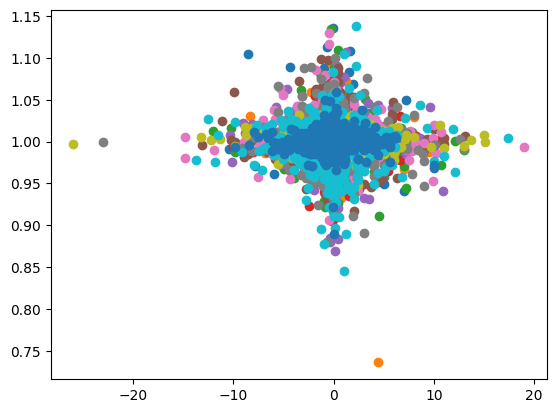

In [14]:
fig, ax = plt.subplots()

for g in np.unique(ticker_list['sector']):
    i = np.where(ticker_list['sector'] == g)
    ax.scatter(ticker_list['esg_change'].iloc[i], ticker_list['return'].iloc[i], label=g)

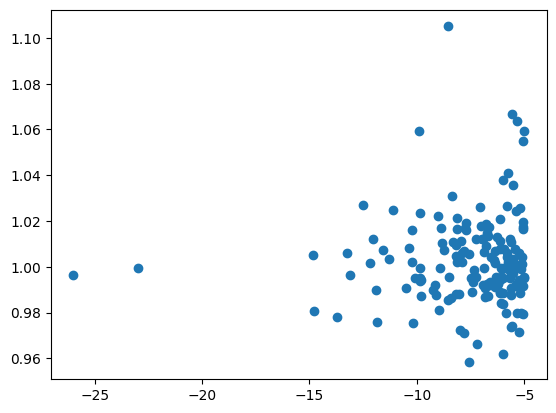

In [17]:
fig, ax = plt.subplots()
esg_change_point = 5
ax.scatter(ticker_list['esg_change'].loc[ticker_list['esg_change']<-esg_change_point], ticker_list['return'].loc[ticker_list['esg_change']<-esg_change_point], label=g)

In [133]:
adjclose_pivot.pct_change()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-08,NaN,NaN,-1.0,0.0,NaN,NaN,-1.668495,-1.655547,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,NaN,0.075023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-26,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-27,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
esg_refined_no_diff_ardl = esg_refined_no_diff.ffill()
esg_refined_no_diff_ardl = esg_refined_no_diff_ardl.diff().dropna()
esg_refined_no_diff_ardl.index = pd.to_datetime(esg_refined_no_diff_ardl.index)

return_pivot = np.log(adjclose_pivot.pct_change()+1).dropna()
return_pivot

regression = pd.merge(return_pivot['A'], esg_refined_no_diff_ardl['A'], right_index=True, left_index=True)
regression

,A_x,A_y
date,,
2022-01-20,-0.006788,0.00
2022-01-21,-0.014225,0.00
2022-01-24,0.004426,0.00
2022-01-25,-0.026038,0.00
2022-01-26,-0.007908,0.00
2022-01-27,-0.010693,0.00
2022-01-28,0.036935,0.00
2022-01-31,0.016355,0.00
2022-02-01,0.012199,-1.24


In [144]:
from arch.univariate import ARX

from arch.univariate import  GARCH, Normal

am = ARX(regression['A_y'], lags=0)
am.volatility = GARCH(1, 0, 1)
am.distribution = Normal()

res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 16.73501207558757
Iteration:      2,   Func. Count:     15,   Neg. LLF: 6.97171607843352
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3.6516262584055355
Iteration:      4,   Func. Count:     27,   Neg. LLF: 4.480493230831368
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3.5921458802760684
Iteration:      6,   Func. Count:     38,   Neg. LLF: 3.5873712235826853
Iteration:      7,   Func. Count:     43,   Neg. LLF: 3.5871719365292636
Iteration:      8,   Func. Count:     48,   Neg. LLF: 3.5871685811603395
Iteration:      9,   Func. Count:     52,   Neg. LLF: 3.587168610139645
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.5871685811603395
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9


In [158]:
regression

,A_x,A_y
date,,
2022-01-20,-0.006788,0.00
2022-01-21,-0.014225,0.00
2022-01-24,0.004426,0.00
2022-01-25,-0.026038,0.00
2022-01-26,-0.007908,0.00
2022-01-27,-0.010693,0.00
2022-01-28,0.036935,0.00
2022-01-31,0.016355,0.00
2022-02-01,0.012199,-1.24


In [155]:
import arch

am2 = arch.univariate.arch_model(100*regression['A_x'], x=regression['A_y'], mean='arx', lags=[1,2], vol='GARCH', p=1, o=0, q=1, power=2.0, dist='t', hold_back=None, rescale=None)
res2 = am2.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 68.07791450870351
Iteration:      2,   Func. Count:     21,   Neg. LLF: 14.654712518047901
Iteration:      3,   Func. Count:     31,   Neg. LLF: 13.957145890421387
Iteration:      4,   Func. Count:     40,   Neg. LLF: 13.94309554396189
Iteration:      5,   Func. Count:     49,   Neg. LLF: 13.977254111447571
Iteration:      6,   Func. Count:     59,   Neg. LLF: 13.923100121068847
Iteration:      7,   Func. Count:     68,   Neg. LLF: 13.922860103668349
Iteration:      8,   Func. Count:     77,   Neg. LLF: 13.92244667697237
Iteration:      9,   Func. Count:     86,   Neg. LLF: 13.92200716716712
Iteration:     10,   Func. Count:     95,   Neg. LLF: 13.921784083330742
Iteration:     11,   Func. Count:    104,   Neg. LLF: 13.921709629966704
Iteration:     12,   Func. Count:    113,   Neg. LLF: 13.921643993358622
Iteration:     13,   Func. Count:    122,   Neg. LLF: 13.92146810649985
Iteration:     14,   Func. Count:    131,   Neg. LLF: 13

c:\Users\User\anaconda3\envs\AQI\lib\site-packages\arch\univariate\base.py:756: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [156]:
print(res2.summary())

                             AR-X - GARCH Model Results                             
Dep. Variable:                          A_x   R-squared:                       0.058
Mean Model:                            AR-X   Adj. R-squared:                 -0.883
Vol Model:                            GARCH   Log-Likelihood:               -13.6212
Distribution:      Standardized Student's t   AIC:                           43.2424
Method:                  Maximum Likelihood   BIC:                           42.8097
                                              No. Observations:                    7
Date:                      Sat, May 06 2023   Df Residuals:                        3
Time:                              08:55:28   Df Model:                            4
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const  

In [4]:
with open(f'../data/panmure/gp_esg_stock_data_frame.pkl', 'rb') as handle:
    gp_esg_stock = pickle.load(handle)

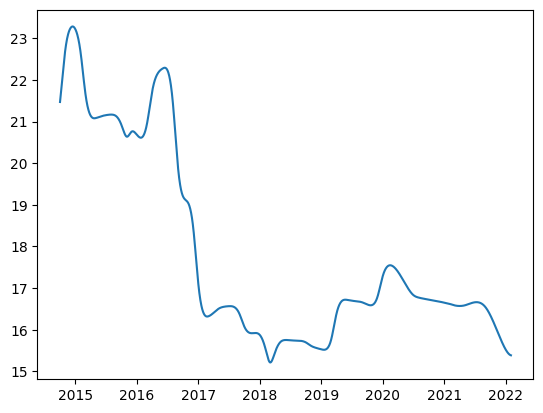

In [65]:
plt.plot(gp_esg_stock['A'])

In [9]:
gp_esg_stock.loc[:, np.isin(gp_esg_stock.columns, sector_classification['Energy'])].mean(axis=1)

date
2014-10-01    31.488551
2014-10-02    31.492801
2014-10-03    31.497280
2014-10-04    31.501983
2014-10-05    31.506907
                ...    
2022-01-28    32.127545
2022-01-29    32.131011
2022-01-30    32.134376
2022-01-31    32.137631
2022-02-01    32.140769
Length: 2681, dtype: float64

# Financial interdependancies

In [11]:
with open(f'../data/panmure/gaussian_nr_quad_10_etf_element-wise.pkl', 'rb') as handle:
    g_dict = pickle.load(handle)

with open(f'../data/panmure/t_nr_quad_10_etf_element-wise.pkl', 'rb') as handle:
    t_dict = pickle.load(handle)

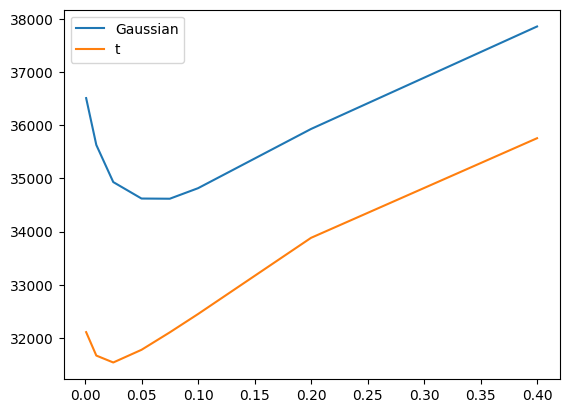

In [36]:
# aic
plt.plot(t_dict['alphas'], g_dict['AIC'][0], label = 'Gaussian')
plt.plot(t_dict['alphas'], t_dict['AIC'][3], label = 't')
plt.legend()

theta

In [12]:
nr_pos_cons = dict()
nr_neg_cons = dict()


thetas = np.array(t_dict['thetas'][3][2]).copy()
thetas[np.abs(thetas)<1e-2] = 0

T = len(thetas)
index = np.array(range(11))
for i in range(11):
    nr_pos_cons[i] = np.array([np.sum(thetas[k,i,index != i] > 0) for k in range(T)])
    nr_neg_cons[i] = np.array([np.sum(thetas[k,i,index != i] < 0) for k in range(T)])

In [51]:
t_dict['time_change'][20::20]

DatetimeIndex(['2018-01-29', '2018-02-27', '2018-03-27', '2018-04-25',
               '2018-05-23', '2018-06-21', '2018-07-20', '2018-08-17',
               '2018-09-17', '2018-10-15', '2018-11-12', '2018-12-12',
               '2019-01-11', '2019-02-11', '2019-03-12', '2019-04-09',
               '2019-05-08', '2019-06-06', '2019-07-05', '2019-08-02',
               '2019-08-30', '2019-09-30', '2019-10-28', '2019-11-25',
               '2019-12-24', '2020-01-24', '2020-02-24', '2020-03-23',
               '2020-04-21', '2020-05-19', '2020-06-17', '2020-07-16',
               '2020-08-13', '2020-09-11', '2020-10-09', '2020-11-06',
               '2020-12-07', '2021-01-06', '2021-02-04', '2021-03-05',
               '2021-04-05', '2021-05-03', '2021-06-01', '2021-06-29',
               '2021-07-28', '2021-08-25', '2021-09-23', '2021-10-21',
               '2021-11-18', '2021-12-17', '2022-01-18', '2022-02-15',
               '2022-03-16', '2022-04-13'],
              dtype='datetime64[n

In [56]:
t_dict['X'].columns


Index(['IYR', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY',
       'XTL'],
      dtype='object')

In [23]:
sector_classification.keys()

dict_keys(['Industrials', 'Healthcare', 'Technology', 'Communication Services', 'Consumer Defensive', 'Consumer Cyclical', 'Utilities', 'Financial Services', 'Basic Materials', 'Real Estate', 'Energy'])

In [66]:
tick_to_sector = dict()
tick_to_sector['XLE'] = 'Energy'
tick_to_sector['XLI'] = 'Industrials'
tick_to_sector['XLF'] = 'Financial Services'
tick_to_sector['XLU'] = 'Utilities'
tick_to_sector['XLV'] = 'Healthcare'
tick_to_sector['XLY'] = 'Consumer Cyclical'
tick_to_sector['XLB'] = 'Basic Materials'
tick_to_sector['IYR'] = 'Real Estate'
tick_to_sector['XLK'] = 'Technology'
tick_to_sector['XLP'] = 'Consumer Defensive'
tick_to_sector['XTL'] = 'Communication Services'

In [67]:
import requests
import yfinance as yf
import pickle
ticker_list = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'IYR', 'XTL']
groups_according_to_ticker = np.array([0, 2, 0, 0,2,2,1,1,0,2,1])
start_date= "2016-01-01"
end_date="2023-02-01"

data = yf.download(ticker_list, start_date , end_date)
returns = data['Adj Close'].pct_change().dropna()
log_returns = np.log(1+data['Adj Close'].pct_change()).dropna()
log_returns_scaled = 100*log_returns.copy()#scaler.fit_transform(log_returns)
price = data['Adj Close'].iloc[1:]
groups = np.array([j for _,j in sorted(zip(ticker_list, groups_according_to_ticker))])  

gogn = {'data':data, 'ticker_list':ticker_list, 'groups_according_to_ticker':groups_according_to_ticker, 'log_returns':log_returns,'returns':returns,
        'log_returns_scaled':log_returns_scaled, 'price':price, 'groups':groups}

[*********************100%***********************]  11 of 11 completed


In [73]:
df.rename(columns=tick_to_sector, inplace=True)

<AxesSubplot: xlabel='Date'>

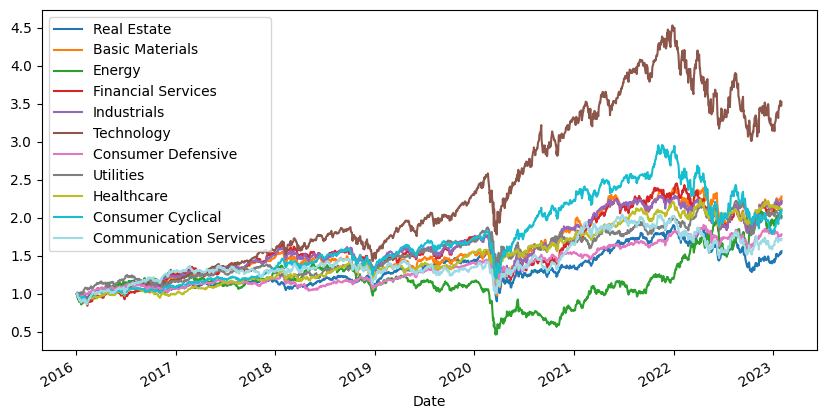

In [76]:
from matplotlib import cm
start = 0.0
stop = 1.0
number_of_lines= 11
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ cm.tab20(x) for x in cm_subsection ]

df = data['Adj Close']/data['Adj Close'].iloc[0]
df.rename(columns=tick_to_sector, inplace=True)
fig, ax = plt.subplots(1,1, figsize = (10,5))
df.plot(ax = ax, color = colors)

In [34]:
6 % 6

0

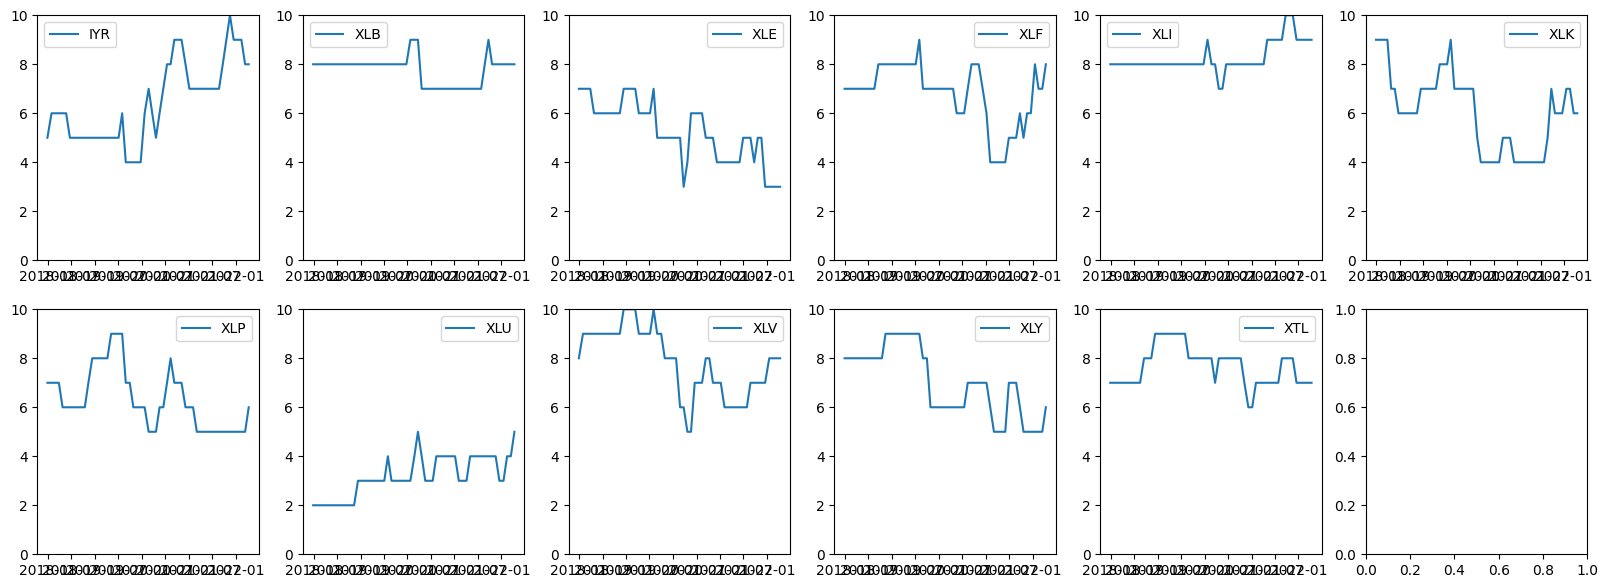

In [39]:
fig, ax = plt.subplots(2,6, figsize = (20,7))

for i in range(11):
    k = int(i/6)
    j = i % 6
    ax[k,j].plot(t_dict['time_change'][::20], nr_neg_cons[i], label = t_dict['X'].columns[i])
    esg_tmp = gp_esg_stock.loc[:, np.isin(gp_esg_stock.columns, sector_classification[tick_to_sector[t_dict['X'].columns[i]]])].mean(axis=1)/3
    esg_tmp = esg_tmp.loc[esg_tmp.index >= datetime.date(2018,1,1)]
    #ax[k,j].plot(esg_tmp)
    ax[k,j].legend()
    ax[k,j].set_ylim((0,10))

t_dict['theta]

# drought data

In [233]:

usa = pd.read_csv("../data/soil/usa.csv")

usa['MapDate'] = usa['MapDate'].astype(str)
usa = usa.loc[usa['State'] == 'CA']
usa['County'] = usa['County'].str.replace(' County', '')
usa['date'] = pd.to_datetime(usa['MapDate'].str[:4] + '/' + usa['MapDate'].str[4:6] + '/' + usa['MapDate'].str[6:8])
usa = usa[['County', 'date', 'DSCI']].pivot(index = 'date', columns='County', values='DSCI')

In [221]:
usa.head()

County,Alameda,Alpine,Amador,Butte,Calaveras,Colusa,Contra Costa,Del Norte,El Dorado,Fresno,...,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
date,,,,,,,,,,,,,,,,,,,,,
2000-05-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-05-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-05-16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-05-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000-05-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
gls = dg.dygl_inner_em(usa.iloc[:1200]/100, obs_per_graph= 20, max_iter = 500, lamda = 0.05, kappa = 0.1, tol = 1e-3, lik_type="gaussian")
gls.fit(nr_workers=1, temporal_penalty="element-wise",verbose=True)


Error 3.68E-2: 100%|██████████| 500/500 [00:25<00:00, 19.33it/s]


In [ ]:
AICs = np.empty((len(graph_sampling_testing['kappas']), len(graph_sampling_testing['alphas'])))

pbar = tqdm.tqdm(total = np.prod(AICs.shape))

for k_cnt, kappa in enumerate(graph_sampling_testing['kappas']):
    for a_cnt, kappa in enumerate(graph_sampling_testing['alphas']):
        try:
            thetas = graph_sampling_testing['thetas'][k_cnt][a_cnt]
            liks = log_lik_all(300, thetas, graph_sampling_testing['X'], 'gaussian')
            nr_params_val = find_nr_params(thetas, 't')
            AICs[k_cnt, a_cnt] = 2*(np.sum(nr_params_val) - np.sum(liks))
        except:
            continue

        pbar.update()
pbar.close()



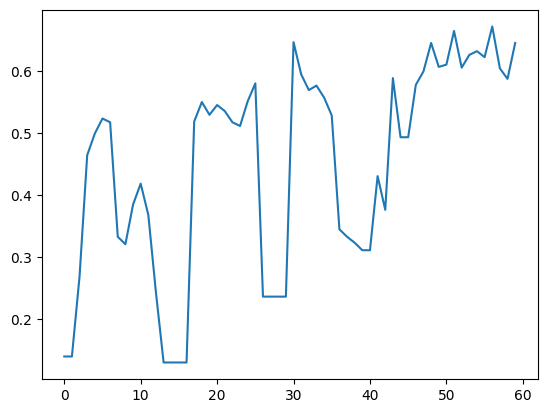

In [187]:
thetas = gls.theta.copy()
d = thetas[0].shape[0]
for theta in thetas:
    np.fill_diagonal(theta,0)
thetas[np.abs(thetas)<1e-2] = 0

nr_connections = [np.sum(np.abs(thetas[i])> 0)/(d*(d-1)/2) for i in range(len(thetas))]
plt.plot(nr_connections)

In [ ]:
nr_pos_cons = dict()
nr_neg_cons = dict()


thetas = np.array(t_dict['thetas'][3][2]).copy()
thetas[np.abs(thetas)<1e-2] = 0

T = len(thetas)
index = np.array(range(11))
for i in range(11):
    nr_pos_cons[i] = np.array([np.sum(thetas[k,i,index != i] > 0) for k in range(T)])
    nr_neg_cons[i] = np.array([np.sum(thetas[k,i,index != i] < 0) for k in range(T)])

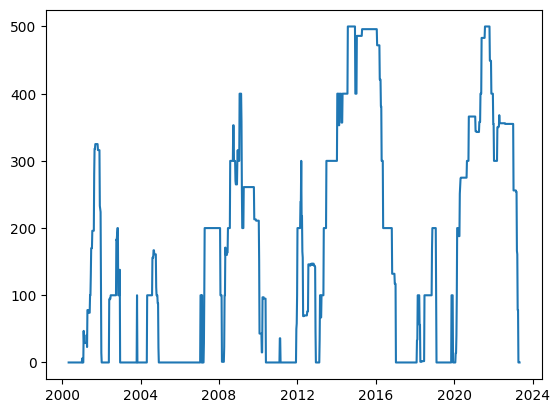

In [166]:
plt.plot(usa.index, usa['Butte County'].rolling(1).mean())

In [138]:
usa.index.month.astype('str')

Index(['5', '5', '5', '5', '5', '6', '6', '6', '6', '7',
       ...
       '2', '3', '3', '3', '3', '4', '4', '4', '4', '5'],
      dtype='object', name='date', length=1201)

In [142]:
np.array(usa.index.month.astype('str'))

array(['5', '5', '5', ..., '4', '4', '5'], dtype=object)

In [158]:
from sklearn.linear_model import LinearRegression


X = np.array([np.array(usa.index.month.astype(str)),
    np.array(usa.index.year.astype(float)),
    np.ones(len(usa.index))]).T
y = usa['Alameda County']

model = LinearRegression().fit(X,y)

In [159]:
X

array([['5', 2000.0, 1.0],
       ['5', 2000.0, 1.0],
       ['5', 2000.0, 1.0],
       ...,
       ['4', 2023.0, 1.0],
       ['4', 2023.0, 1.0],
       ['5', 2023.0, 1.0]], dtype=object)

In [154]:
y

date
2000-05-02    0
2000-05-09    0
2000-05-16    0
2000-05-23    0
2000-05-30    0
             ..
2023-04-04    0
2023-04-11    0
2023-04-18    0
2023-04-25    0
2023-05-02    0
Name: Alameda County, Length: 1201, dtype: int64

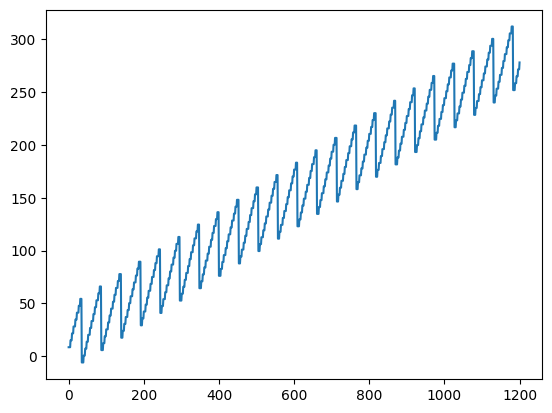

In [161]:
plt.plot(model.predict(X))

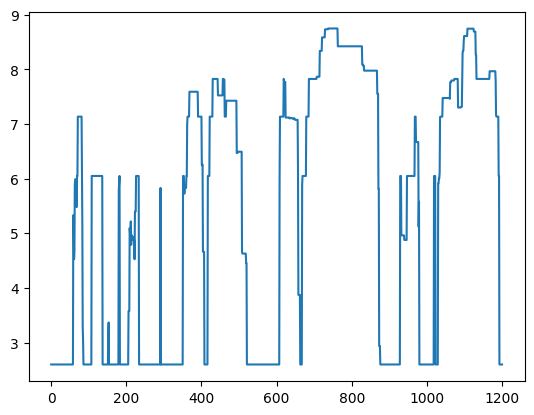

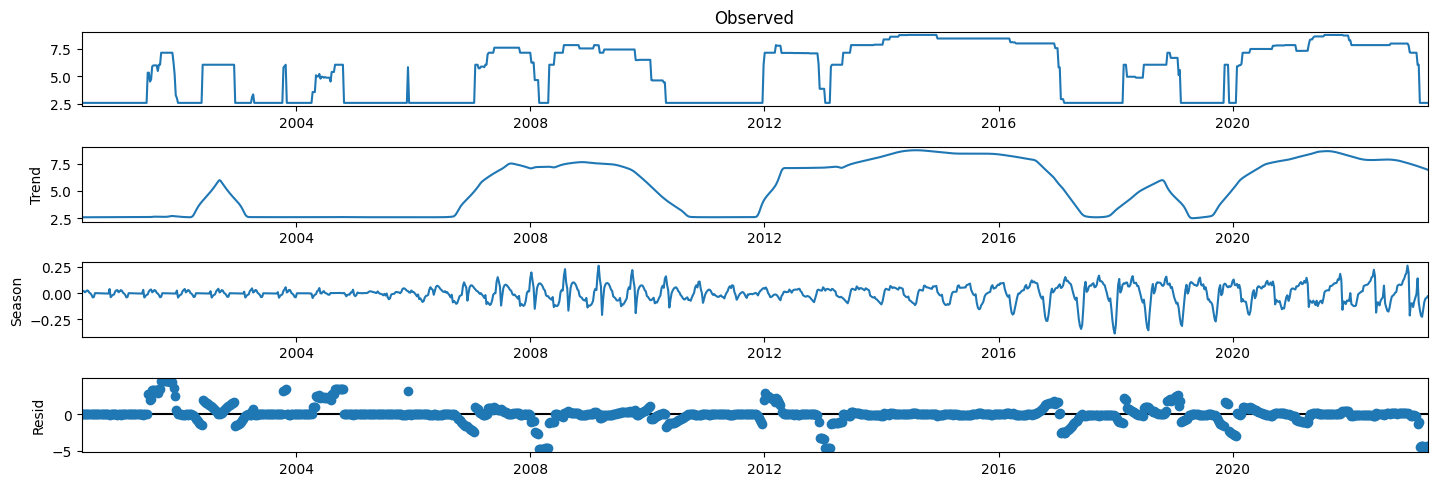

In [133]:
from scipy.stats import shapiro 
from statsmodels.tsa.seasonal import STL
from pmdarima.arima import auto_arima
from scipy.stats import boxcox
import statsmodels.api as sm
import pickle

xt, _ = boxcox(usa['Alameda County']+10)
xt_df = pd.DataFrame(xt, index = usa.index)
plt.plot(xt)

stl = STL(xt_df, seasonal=13, period = 30, robust = True)
res = stl.fit()
fig = res.plot()
fig.set_size_inches((16, 5))
out = auto_arima(res.resid, seasonal=False)

(array([1.000e+00, 1.000e+00, 5.000e+00, 9.000e+00, 2.600e+01, 1.126e+03,
        2.100e+01, 6.000e+00, 3.000e+00, 3.000e+00]),
 array([-3.88471738, -3.16163956, -2.43856174, -1.71548392, -0.9924061 ,
        -0.26932828,  0.45374954,  1.17682736,  1.89990518,  2.622983  ,
         3.34606082]),
 <BarContainer object of 10 artists>)

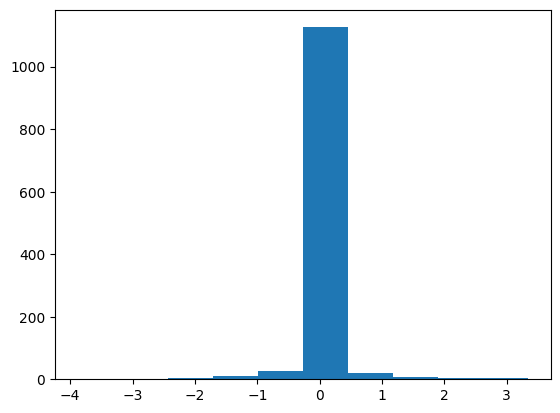

In [132]:
out.resid

In [ ]:
import geopandas as gpd
shape_in = gpd.read_file('../../ca-county-boundaries/CA_Counties/CA_COUNTIES_TIGER2016.shp')

#points_in_poly = generate_grid_in_polygon(0.25, shape_in)
#points_in_poly_gdf = gpd.GeoDataFrame(geometry=points_in_poly)

ax1 = shape_in.plot(facecolor='none', edgecolor='k')
# ax1.plot(coord_list[0][0], coord_list[0][1])
#ax1 = points_in_poly_gdf.plot(ax=ax1)